In [1]:
from dotenv import load_dotenv

import os

load_dotenv()

True

## Checando Tools 

Vamos importar as tools criadas anteriormente! 

In [2]:
from tools import *

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
trends = create_trends_tool()
trends_text = trends.invoke({"country": "brazil", 
                             "head": 3})
trends_list = to_list(trends_text)
trends_list

['João Fonseca', 'Lakers x Heat', 'Bia Haddad']

In [4]:
contents_news = get_serper_with_scrapping(trends_list, k=5)

100%|██████████| 3/3 [00:13<00:00,  4.54s/it]


In [5]:
contents_news

{'João Fonseca': [{'title': 'Bia Haddad avança no Australian Open; João Fonseca é eliminado',
   'link': 'https://www.cnnbrasil.com.br/esportes/tenis/bia-haddad-avanca-no-australian-open-joao-fonseca-e-eliminado/',
   'snippet': 'O começo de quinta-feira (16) foi agridoce para o torcedor brasileiro que vem acompanhando o Australian Open. Isso porque Beatriz Haddad...',
   'date': 'há 7 horas',
   'source': 'CNN Brasil',
   'imageUrl': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSmNiIn5DMqhnsq0-IqeXi_wmD7nfH7TCyv9CyF8w7z2ua555bCeE8ZlrM&usqp=CAI&s',
   'position': 1,
   'content': '               Bia Haddad avança no Australian Open; João Fonseca é eliminado | CNN Brasil                                                Ao Vivo    COP 30    Política    Política    Notícias     William Waack      Internacional    Nacional    Economia    Economia    Notícias     Investimentos     Mercado     Cotações     Loterias    Loterias   Mega Sena   Quina   Lotofacil   Lotomania   Duplasena  

## Construção do Agent

Para construir o agente, vamos utilizar as funções que construimos anteriormente. A ideia central é um agente que colete quais são as tendências de pesquisa no Google Trends, pesquise essas tendências no Google Api (SerpApi), faça scrapping dos resultados e crie uma newsletter com as informações. Para a construção desses fluxos, é comum fazermos o desenho do fluxo (que pode ser representado por um grafo).

<img src="../imgs/agent_trends.png" width="800">

Os componentes do agente são:

1. ``Estado``: é o objeto que irá armazenar as informações do agente ao longo do grafo.
2. ``Nós``: são as funções que irão realizar as ações do agente.
3. ``Transições (arestas)``: são as funções que irão decidir qual será o próximo nó a ser executado (ela pode ser condicional ou não).

### Estado do Grafo

In [6]:
from typing_extensions import TypedDict
from typing import List, Dict, Any

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        country: country of the trends
        head: number of trends to get
        k: number of news to get
        trends: list of trends
        news: dict of news about each trend
        newsletter: newsletter from the news
    """
    country: str
    head: int
    k: int
    trends: List[str]
    news: dict
    soccer_news: dict
    subjects: List[str] # New attribute
    favorite_team: str # New attribute
    newsletter: str

### Chains

Aqui definimos as cadeias de execução do agente. Normalmente separamos dessa forma pra que a construção dos nós fique mais organizada.

In [7]:

from operator import itemgetter
from typing import TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnablePassthrough
from langchain_openai import ChatOpenAI
# from langchain_groq import ChatGroq

def format_news(news: dict) -> str:
    """
    Format the news to be used in the newsletter.

    Args:
        news: dict of news about each trend

    Returns:
        str: formatted news
    """
    news_str = ""
    for trend, content in news.items():
        news_str += f"-----**{trend}**-----\n"
        for i, new in enumerate(content):
            title = new["title"]
            txt_content = new["content"]
            link = new["link"]
            
            news_str += f"""
            title: {title}
            link: {link}
            content: {txt_content}
            """
        news_str += "\n"
    return news_str

def write_newsletter(news: dict, 
                     provider: str="openai",
                     model_name: str="gpt-4o-mini",
                     temperature: float=0.2) -> str:
    """
    Generate a newsletter from the news.
    
    Args:
        news: dict of news about each trend
        provider: provider of the language model
        model_name: name of the language model
        temperature: temperature of the language model
        
    Returns:
        str: newsletter from the news
    """
    
    if provider == "openai": # Sugestão: gpt-4o-mini
        llm = ChatOpenAI(model=model_name, temperature=temperature)
    # elif provider == "groq": # Sugestão: llama-3.3-70b-versatile
    #     llm = ChatGroq(model=model_name, temperature=temperature)

    formatted_news = format_news(news)

    system_prompt = """
    Você é um assistente pessoal que vai escrever um newsletter sobre as notícias do dia que foram extraidas do Google Trends. Sua tarefa é resumir o conteúdo das notícias e escrever um texto informativo e interessante para o usuário. 
    
    Obs.: Sempre que possível, cite a fonte das notícias colocando o link de onde ela foi tirada.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "Aqui está todo o conteúdo que você vai usar para fazer a newsletter: {input}"),
        ]
    )

    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke({"input": formatted_news})
    
    return response

## LLM Classifier Tool

In [8]:
from pydantic import BaseModel, Field
from typing import List

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

In [9]:
class GetSchema(BaseModel):
    """Schema de bolo"""
    
    resultado: str = Field(description="YES caso o texto fale de FUTEBOL e NO caso contrário", examples=['YES', 
                                                                                                        'NO'])

def llm_structured_extraction_classifier(model_name_openai = "gpt-4o-2024-08-06"):

    llm_openai = ChatOpenAI(
        model=model_name_openai,
        temperature=0,
    )

    system_prompt = """
        Você é um assistente de IA muito prestativo que vai auxiliar um jornalista a classificar textos que falam especificamente sobre FUTEBOL.
        Você precisa classificar o texto como YES ou NO, dependendo se o texto fala de futebol ou não.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt), 
            ("human", "query do usuário: \n\n {query}")
        ]
    )

    llm_openai_with_tools_extraction = llm_openai.bind_tools([GetSchema])
    chain_openai_structured_extraction = prompt | llm_openai_with_tools_extraction

    return chain_openai_structured_extraction

In [10]:
def classify_soccer_news(news: dict, 
                         model_name_openai = "gpt-4o-2024-08-06") -> dict:
    """
    Classify the news as soccer or not soccer.
    
    Args:
        news: dict of news about each trend
        model_name_openai: name of the language model
    """

    chain_openai_structured_extraction = llm_structured_extraction_classifier(model_name_openai)

    soccer_news = {}

    for trend, content in news.items():
        soccer_news[trend] = []
        for i, new in enumerate(content):
            # title = new["title"]
            txt_content = new["content"]
            # link = new["link"]
            
            response = chain_openai_structured_extraction.invoke({"query": txt_content})
            resultado = response.tool_calls[0]["args"]["resultado"]

            if resultado == "YES":
                soccer_news[trend].append(new)
    
    filtered_soccer_news = {k: v for k, v in soccer_news.items() if v}
    
    return filtered_soccer_news

### Nodes

Aqui vamos definir os nós do grafo! Como dito anteriormente, entenda os nós como sendo funções a serem executadas. Cada entrada de um nó é a saída de um nó anterior, cada execução de nó podemos ou não modificar o estado do grafo (definido anteriormente).

In [11]:
from IPython.display import Markdown

def get_trends(state: GraphState) -> dict:
    """
    Get trends from Google Trends

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET TRENDS---")
    print()
    country = state["country"]
    head = state["head"]
    subjects = state["subjects"] # New attribute
    
    if subjects:
        print("--> Assuntos adicionais: ", subjects) # New print
 
    # Get trends
    trends = create_trends_tool()
    trends_text = trends.invoke({"country": country, 
                                 "head": head})
    trends_list = to_list(trends_text)
    
    print("Trend List: ", trends_list)
    print()
    
    return {"country": country, 
            "head": head, 
            "trends": trends_list}

def get_serper_and_scrapping(state: GraphState) -> dict:
    """
    Get news from SerpAPI and scrap the content

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---GET SERPER AND SCRAPPING---")
    print()
    trends = state["trends"]
    k = state["k"]
    subjects = state["subjects"] # New attribute
    
    # Get news
    news = get_serper_with_scrapping(queries=trends + subjects, k=k)
    keys_from_serper = news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(news[trend]))):
            print(news[trend][i]["title"])
        print()
    
    return {"news": news}

def filter_soccer_news(state: GraphState) -> dict:
    """
    Filter soccer news from the news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---FILTER SOCCER NEWS---")
    print()
    
    news = state["news"] # Get the news from GraphState that the previous node returned
    soccer_news = {}
    
    # Filter soccer news with tool
    soccer_news = classify_soccer_news(news)
    
    # Print some titles
    for trend, content in soccer_news.items():
        print(f"---{trend}---")
        for i in range(min(3, len(content))):
            print(content[i]["title"])
        print()
    
    return {"soccer_news": soccer_news}

def create_newsletter(state: GraphState) -> dict:
    """
    Create a newsletter from the news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """

    print("---CREATE NEWSLETTER---")
    print()
    news = state["soccer_news"]
    
    # Create newsletter
    newsletter = write_newsletter(news=news, 
                                  provider="openai",
                                  model_name="gpt-4o-mini",
                                  temperature=0.2)
    print("Aqui está a newsletter: ", newsletter)
    display(Markdown(newsletter))
    return {"newsletter": newsletter}

## Conditional Nodes

In [59]:
def search_favorite_team_news(state: GraphState) -> dict:
    """
    Search for the favorite team news

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): 
    """
    print("---SEARCH FAVORITE TEAM NEWS---")
    print()
    # news = state["news"]
    favorite_team = state["favorite_team"]
    k = state["k"]
    
    favorite_team_news = get_serper_with_scrapping(queries=[favorite_team], k=k)
    keys_from_serper = favorite_team_news.keys()
    
    # Print some titles
    for trend in keys_from_serper:
        print(f"---{trend}---")
        for i in range(min(3, len(favorite_team_news[trend]))):
            print(favorite_team_news[trend][i]["title"])
        print()
    
    return {"soccer_news": favorite_team_news}

In [75]:
def has_soccer_news(state: GraphState) -> str:
    """
    Check if there are soccer news

    Args:
        state (dict): The current graph state

    Returns:
        node (str): 
    """
    soccer_news = state["soccer_news"]

    return "create_newsletter" if soccer_news else "search_favorite_team_news"

### Workflow

Por fim, com os nós construidos e as cadeias definidas, podemos construir o workflow do agente.

In [84]:
from langgraph.graph import END, StateGraph

def compile_workflow():
    """ 
    Compiles the workflow for creating a newsletter from Google Trends.
    
    Returns:
        app (StateGraph): The compiled workflow.
    """
    
    # Define the graph
    workflow = StateGraph(GraphState)
    
    # Define the nodes
    workflow.add_node("get_trends", get_trends)
    workflow.add_node("get_serper_and_scrapping", get_serper_and_scrapping)
    workflow.add_node("filter_soccer_news", filter_soccer_news)
    workflow.add_node("search_favorite_team_news", search_favorite_team_news)
    workflow.add_node("create_newsletter", create_newsletter)

    # Build graph
    workflow.set_entry_point('get_trends')
    workflow.add_edge("get_trends", "get_serper_and_scrapping")
    workflow.add_edge("get_serper_and_scrapping", "filter_soccer_news")
    # workflow.add_edge("filter_soccer_news", "create_newsletter")
    
    workflow.add_conditional_edges(
        "filter_soccer_news",
        has_soccer_news,
        {
            "search_favorite_team_news": "search_favorite_team_news",
            "create_newsletter": "create_newsletter"
        },
    )

    workflow.add_edge("search_favorite_team_news", "create_newsletter")
    
    workflow.add_edge("create_newsletter", END)
    # workflow.set_finish_point("create_newsletter")

    # Compile
    app = workflow.compile()
    return app

In [85]:
app = compile_workflow()

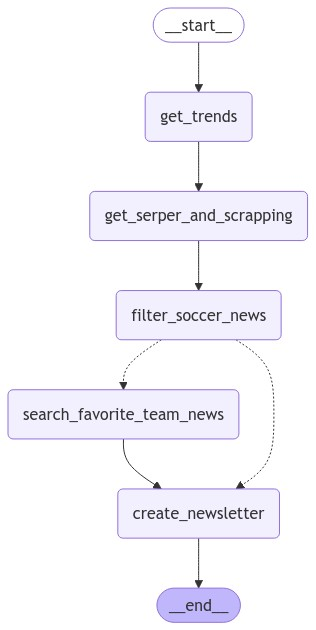

In [86]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [87]:
response = app.invoke({"country": "brazil",
                       "head": 1,
                       "subjects": [],
                       "favorite_team": "Flamengo",
                       "k": 3})

---GET TRENDS---

Trend List:  ['João Fonseca']

---GET SERPER AND SCRAPPING---



100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


---João Fonseca---
Where to watch João Fonseca x Lorenzo Sonego live in the second round of the Australian Open 2025 this Thu ...
João Fonseca: saiba quando devem ser próximos jogos após Australian Open
Após Australian Open, saiba quais são os próximos torneios de João Fonseca

---FILTER SOCCER NEWS---

{'soccer_news': {}, 'country': 'brazil', 'head': 1, 'k': 3, 'trends': ['João Fonseca'], 'news': {'João Fonseca': [{'title': 'Where to watch João Fonseca x Lorenzo Sonego live in the second round of the Australian Open 2025 this Thu ...', 'link': 'https://www.mixvale.com.br/2025/01/16/where-to-watch-joao-fonseca-x-lorenzo-sonego-live-in-the-second-round-of-the-australian-open-2025-this-thursday/', 'snippet': "João Fonseca, a rising star in Brazilian tennis, returns to the court this Thursday, January 16, to face Italy's Lorenzo Sonego in the...", 'date': 'há 13 horas', 'source': 'Mix Vale', 'imageUrl': 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQF0HsL9emDOK6Cke6oVmKIEQ1fRjons

100%|██████████| 1/1 [00:08<00:00,  8.58s/it]


---Flamengo---
Fla tem nova onda de saídas, demite funcionários e dispensa atletas da base
Bastidores: Flamengo promove demissão em massa na base; jogadores, treinadores e outros profissionais dão adeus ao clube
Flamengo promove demissão em massa no futebol de base

---CREATE NEWSLETTER---

Aqui está a newsletter:  **Newsletter de Notícias do Flamengo - 16 de Janeiro de 2025**

Olá, torcedores rubro-negros! Aqui estão as principais notícias do Flamengo que estão em alta hoje:

### 1. Demissões em Massa nas Categorias de Base
O Flamengo está passando por uma reestruturação significativa em suas categorias de base, resultando na demissão de mais de 50 funcionários, incluindo treinadores e jogadores. Entre os demitidos estão treinadores das categorias sub-11 ao sub-16 e o comandante do time B do sub-20, Raphael Bahia. A nova gestão, liderada por Luiz Eduardo Baptista (Bap), visa alinhar as categorias de base à filosofia do futebol profissional do clube. A expectativa é que novas contrataç

**Newsletter de Notícias do Flamengo - 16 de Janeiro de 2025**

Olá, torcedores rubro-negros! Aqui estão as principais notícias do Flamengo que estão em alta hoje:

### 1. Demissões em Massa nas Categorias de Base
O Flamengo está passando por uma reestruturação significativa em suas categorias de base, resultando na demissão de mais de 50 funcionários, incluindo treinadores e jogadores. Entre os demitidos estão treinadores das categorias sub-11 ao sub-16 e o comandante do time B do sub-20, Raphael Bahia. A nova gestão, liderada por Luiz Eduardo Baptista (Bap), visa alinhar as categorias de base à filosofia do futebol profissional do clube. A expectativa é que novas contratações sejam feitas nos próximos dias. [Leia mais no UOL](https://www.uol.com.br/esporte/futebol/ultimas-noticias/2025/01/16/fla-tem-nova-onda-de-saidas-demite-funcionarios-e-dispensa-atletas-da-base.htm) e [Coluna do Fla](https://colunadofla.com/2025/01/bastidores-flamengo-promove-demissao-em-massa-na-base-jogadores-treinadores-e-outros-profissionais-dao-adeus-ao-clube/).

### 2. Novo Patrocínio com a Shopee
A Shopee se tornou a nova patrocinadora do Flamengo, com um contrato de R$ 12 milhões por ano. A marca estará presente na manga das camisas dos times de futebol masculino e feminino, além do time de basquete. O acordo inclui a criação de uma loja oficial do Flamengo na plataforma da Shopee, que será lançada em breve. Essa parceria é parte da estratégia do Flamengo para diversificar suas fontes de receita e fortalecer sua presença no mercado. [Saiba mais na IstoÉ Dinheiro](https://istoedinheiro.com.br/shopee-patrocinio-flamengo/) e [UOL Economia](https://economia.uol.com.br/noticias/redacao/2025/01/16/como-a-shopee-quer-alavancar-vendas-com-o-patrocinio-ao-flamengo.htm).

### 3. Reforços na Pré-Temporada
O técnico Filipe Luís convocou dois jogadores da base, Pedro Fachinetti e Lucas Vieira, para se juntarem ao elenco principal durante a pré-temporada nos Estados Unidos. Ambos foram parte do time que participou da Copinha, e agora terão a oportunidade de treinar com os profissionais. [Confira mais detalhes na Coluna do Fla](https://colunadofla.com/2025/01/filipe-luis-ganha-2-reforcos-em-pre-temporada-do-flamengo-nos-estados-unidos/).

### 4. Expectativas para o Carioca
Com as mudanças em andamento, o Flamengo se prepara para sua próxima partida no Campeonato Carioca contra o Madureira. A equipe busca se reerguer após as recentes demissões e se concentrar em um desempenho forte na competição. [Veja onde assistir ao jogo](https://colunadofla.com/2025/01/madureira-x-flamengo-onde-assistir/).

Fique ligado para mais atualizações sobre o Flamengo e suas movimentações no futebol! Vamos juntos, nação rubro-negra! 🔴⚫

--- 

Se você deseja mais informações ou tem alguma dúvida, não hesite em entrar em contato!

## Conclusão:

Com essa aplicação simples é possível ver como podemos construir um agente que coleta informações de tendências de pesquisa e cria uma newsletter. Para além dessa ideia, é possível construir aplicações mais robustas, que envolvem ``novos nós, novas cadeias, novos estados ou até transições condicionais``. 

### Tarefa de casa:

1. Crie um novo nó que envie a newsletter por email. Note que para isso você precisa incluir uma lista de emails que irão receber a newsletter. (``Dica:`` Faça a lista de emails ser um parâmetro na entrada do grafo, assim você pode passar a lista de emails como parâmetro para o nó que envia a newsletter).

2. Calcule quanto custa em média uma newsletter. (``Dica:`` Use o LangSmith).

3. Construa um classificador que classifica as notícias de acordo com o assunto. Especificamente, classifique se a notícia fala sobre futebol ou não (``binário``). No fim, faça a newsletter somente baseada em assuntos de futebol (seu classificador será um filtro).

4. Crie um ``conditional_edge`` que verifica se existe noticia ou não de futebol. Caso não tenha noticias de futebol no Google Trends, crie um nó que vai pesquisar sobre seu time de futebol favorito e adicione na newsletter apenas os ultimos assuntos dele.

5. Crie uma ``API`` (com ``FastAPI``, por exemplo), que contenha um endpoint que recebe:

```python
{"country": "brazil",
 "head": 5,
 "k": 3}
 ```

E devolve o estado do grafo.